# NYC Taxi Fare Prediction

In this project, the goal is to build a model and predict the taxi fare in NYC, given time, geographic coordinates of pickup and dropoff location and number of passengers. In original dataset, we have around 55 million rows.

## Loading Original Data

First we set pandas `display.float_format` option to only display 3 digits for better formatting. 

In original dataset, the `key` column contains duplicate information as `pickup_datetime` column. We will not make use of that column, so drop it here. Also drop any null rows.

In [1]:
import math
import pandas
import numpy
import seaborn
import sklearn
import sklearn.linear_model
import sklearn.ensemble
import matplotlib.pyplot as plt
from geopy.distance import geodesic

pandas.set_option('display.float_format', lambda x: '%.3f' % x)

df = pandas.read_csv('sample.csv', parse_dates = ['pickup_datetime'])
df = df.drop(columns='key').dropna()

/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Now take a look at the loaded data:

In [2]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1


We can preview the data by showing its descriptive statistics. The statistics will also help us cleaning the data.

In [3]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000
mean,11.355,-72.495,39.914,-72.491,39.919,1.674
std,9.717,10.694,6.226,10.471,6.213,1.300
min,-44.900,-736.550,-74.008,-84.654,-74.006,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.963,40.768,2.000
max,200.000,40.788,401.083,40.851,404.617,6.000


We can see that there are several suspicious outliers. The minimum value of `pickup_longitude` and maximum value of `pickup_latitude` are impossible. Some other values like 0 and 208 in `passenger_count` should also be considered as fault rows.


## Task 1: Cleaning the Data

##### Taxi fare
The base taxi fare of NYC yellow cab is $2.50. For the upper bound, by intuition, the taxi fare within NYC does not exceed $100 in general cases. 

##### Pickup & Dropoff Locations
By investigating geographic coordinates on Google Map, I found that the difference of latitude and longitude value of 2 extremal points in NYC is less than 2%. Therefore, we will take 2% and 98% percentile of pickup and dropoff location and exclude those does not lie in that range.

##### Passenger Count
In NYC the maximum amount of passengers allowed in a yellow taxicab by law is 4, except that a child under age of 7 is allowed as an extra passenger. A mini van may take up to 7 passengers. We will drop all rows with `passenger_count` is less than 1 or larger than 7.

In [4]:
df = df.drop(df[(df.fare_amount < 2.5) | (df.fare_amount > 100)].index)

df = df.drop(df[(df.pickup_longitude < -75.462) | (df.pickup_longitude > -72.502)].index)
df = df.drop(df[(df.pickup_latitude < 39.937) | (df.pickup_latitude > 41.568)].index)
df = df.drop(df[(df.dropoff_longitude < -75.460) | (df.dropoff_longitude > -72.500)].index)
df = df.drop(df[(df.dropoff_latitude > 41.568) | (df.dropoff_latitude < 39.937)].index)

df = df.drop(df[(df.passenger_count < 1) | (df.passenger_count > 7)].index)

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97484.000,97484.000,97484.000,97484.000,97484.000,97484.000
mean,11.305,-73.975,40.751,-73.974,40.752,1.681
std,9.371,0.041,0.031,0.039,0.034,1.299
min,2.500,-75.425,39.993,-75.355,39.993,1.000
25%,6.000,-73.992,40.737,-73.991,40.736,1.000
50%,8.500,-73.982,40.754,-73.980,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,100.000,-72.857,41.523,-72.855,41.543,6.000


### Calculating Euclidean and Geographic Distance

We will calculate euclidean and geographic distance between pickup and dropoff location in the dataset. Since we have already dropped invalid ones of latitude and longitude values, we can simply apply both distance function to all rows and generate 2 new columns: `eu_distance` as Euclidean distance and `geo_distance` as geographic distance. The grographic distance is in kilometers(km).

In [5]:
def eu_distance(pickup_col, dropoff_col):
    return numpy.sqrt(numpy.sum((pickup_col - dropoff_col.values) ** 2, axis=1))

def geo_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return geodesic(pickup, dropoff).km


pickup_col = df[['pickup_latitude', 'pickup_longitude']]
dropoff_col = df[['dropoff_latitude', 'dropoff_longitude']]

df['eu_distance'] = eu_distance(pickup_col, dropoff_col)
df['geo_distance'] = df.apply(geo_distance, axis=1)

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance
count,97484.000,97484.000,97484.000,97484.000,97484.000,97484.000,97484.000,97484.000
mean,11.305,-73.975,40.751,-73.974,40.752,1.681,0.034,3.346
std,9.371,0.041,0.031,0.039,0.034,1.299,0.042,3.895
min,2.500,-75.425,39.993,-75.355,39.993,1.000,0.000,0.000
25%,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.256
50%,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.158
75%,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.926
max,100.000,-72.857,41.523,-72.855,41.543,6.000,1.470,124.110


We will drop rows which pickup and dropoff locations being too close (less than 0.01km) or too far (more than 100km).

In [6]:
df = df.drop(df[(df.geo_distance > 100) | (df.geo_distance < 0.01)].index)

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance
count,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000
mean,11.287,-73.976,40.751,-73.974,40.751,1.682,0.035,3.381
std,9.252,0.037,0.028,0.036,0.031,1.300,0.040,3.760
min,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010
25%,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287
50%,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.189
75%,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.968
max,100.000,-72.857,41.523,-72.855,41.543,6.000,1.060,99.845


Save cleaned data to csv file to prevent repeated works.

In [7]:
df.to_csv('cleaned.csv')

From now we can directly read from cleaned dataset.

In [8]:
df = pandas.read_csv('cleaned.csv')
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance
count,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000,96170.000
mean,49975.686,11.287,-73.976,40.751,-73.974,40.751,1.682,0.035,3.381
std,28863.749,9.252,0.037,0.028,0.036,0.031,1.300,0.040,3.760
min,0.000,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010
25%,24980.250,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287
50%,49969.500,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.189
75%,74972.750,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.968
max,99998.000,100.000,-72.857,41.523,-72.855,41.543,6.000,1.060,99.845


## Task 2: Computing Pearson correlation

We will compute pearson correlation between:
 - Euclidean distance of the ride and the taxi fare
 - time of day and distance traveled
 - time of day and the taxi fare
 
First, parse `pickup_datetime` to time of days into a new column. The time of the day is represented as integer timestamp in seconds, for instance, 00:00:01 is 1 and 01:00:00 is 3600.

In [9]:
def parse_time_of_day(time):
    time = time.str.extract('(\d\d:\d\d:\d\d)', expand=False)
    hour = time.str.slice(0, 2).astype(int)
    minute = time.str.slice(3, 5).astype(int)
    second = time.str.slice(6).astype(int)
    return hour * 3600 + minute * 60 + second

df['time_of_day'] = parse_time_of_day(df['pickup_datetime'])

df.head()

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day
0,0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,0.009,1.030,62781
1,1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,0.080,8.443,60736
2,2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,0.014,1.389,2100
3,3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,0.025,2.796,16242
4,4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,0.019,1.998,28260


Now `time_of_day` looks good and computable. We will calculate Pearson correlation with the column.

In [10]:
corr1 = df['eu_distance'].corr(df['fare_amount'], method="pearson")
corr2 = df['time_of_day'].corr(df['eu_distance'], method="pearson")
corr3 = df['time_of_day'].corr(df['fare_amount'], method="pearson")

print("Pearson correlation between Euclidesn distance and taxi fare: %.3f" % corr1)
print("Pearson correlation between time of the day and Euclidean distance: %.3f" % corr2)
print("Pearson correlation between time of the day and taxi fare: %.3f" % corr3)

Pearson correlation between Euclidesn distance and taxi fare: 0.862
Pearson correlation between time of the day and Euclidean distance: -0.032
Pearson correlation between time of the day and taxi fare: -0.020


We can see a highest Pearson correlation between Euclidean distance and taxi fare.

## Task 3: Visualizing the Relations

The figures below are visualizing the relations above.

/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


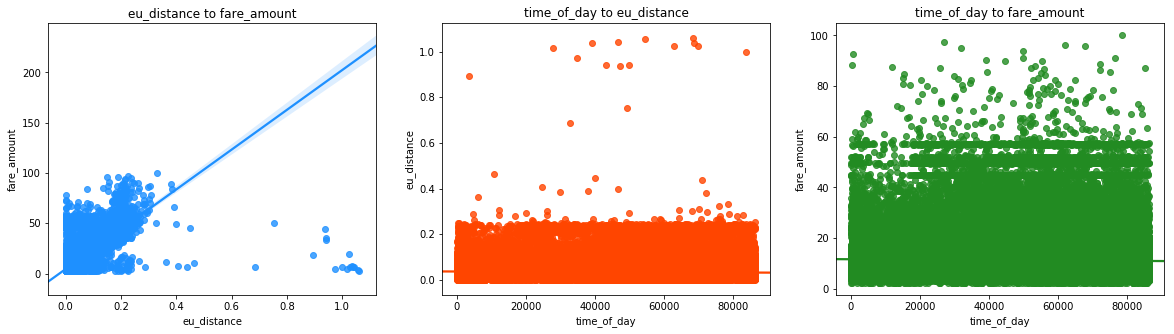

In [11]:
figure, axes = plt.subplots(1, 3, figsize = (20, 5), sharex=False, sharey=False)

seaborn.regplot(x="eu_distance", y="fare_amount", data=df, ax=axes[0], color="dodgerblue")
axes[0].set_title('eu_distance to fare_amount')

seaborn.regplot(x="time_of_day", y="eu_distance", data=df, ax=axes[1], color="orangered")
axes[1].set_title('time_of_day to eu_distance')

seaborn.regplot(x="time_of_day", y="fare_amount", data=df, ax=axes[2], color="forestgreen")
axes[2].set_title('time_of_day to fare_amount')

figure.show()

We can see a relatively clearer linear relation between eu_distance and fare_amount, where as the other 2 pairs does not show a clear linear relation.

## Task 4: Create Plots

In this task I will create 2 plots to show relations between the fields.

The first is a bar plot showing Pearson correlation between passenger_count and other fields.

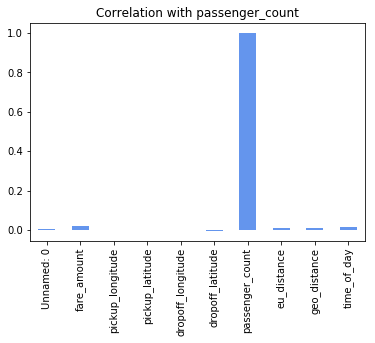

In [12]:
corrs = df.corr(method='pearson')

corrs['passenger_count'].plot.bar(color = 'cornflowerblue');
plt.title('Correlation with passenger_count');

We can see that `passenger_count` have extremely low correlations with other fields. Next, we will use a heat map to compare correlation of each pair over all fields in the dataset.

Text(0.5, 1.0, 'Pearson Correlations of all fields')

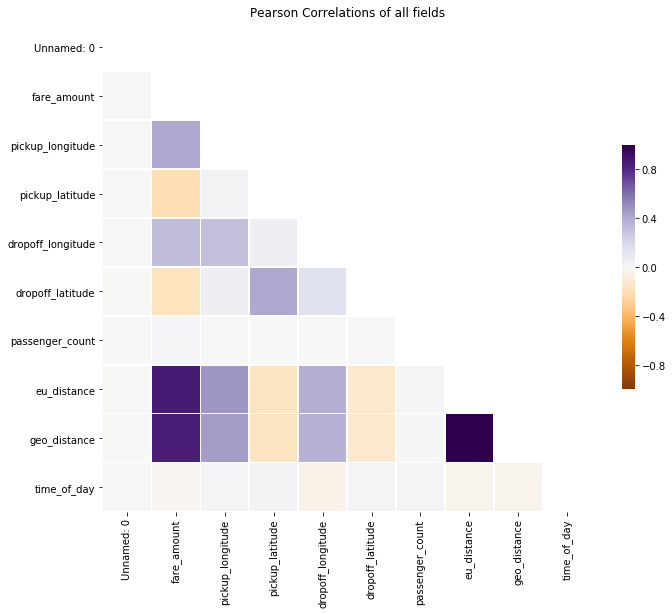

In [13]:
mask = numpy.zeros_like(corrs, dtype=numpy.bool)
mask[numpy.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

seaborn.heatmap(corrs, mask=mask, cmap=plt.cm.PuOr, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Pearson Correlations of all fields")

It is obvious that Euclidean distance is highly correlated to geographic distance, we will disregard that. We can see that except for the pair travel distance and taxi fare, all other pairs does not show a strong relation.

## Task 5: Additional Feature

In this task, I will extract the `year`, `month` and `day_of_week` column from `pickup_datetime`, and try to find its relation to `fare_amount`. Is it true that taxi price is becoming more and more expensive each year, and fare is more expensive on weekends due to the traffic?

In [14]:
def parse_year(time):
    return time.str.slice(0, 4).astype(int)

def parse_month(time):
    return time.str.slice(5, 7).astype(int)

df['year'] = parse_year(df['pickup_datetime'])
df['month'] = parse_month(df['pickup_datetime'])
df['day_of_week'] = pandas.to_datetime(df['pickup_datetime']).dt.dayofweek

df.head()

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day,year,month,day_of_week
0,0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,0.009,1.030,62781,2009,6,0
1,1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,0.080,8.443,60736,2010,1,1
2,2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,0.014,1.389,2100,2011,8,3
3,3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,0.025,2.796,16242,2012,4,5
4,4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,0.019,1.998,28260,2010,3,1


In [15]:
corr_year = df['year'].corr(df['fare_amount'], method="pearson")
print("Pearson correlation between year and taxi fare: %.3f" % corr_year)

corr_month = df['month'].corr(df['fare_amount'], method="pearson")
print("Pearson correlation between month and taxi fare: %.3f" % corr_month)

corr_dow = df['day_of_week'].corr(df['fare_amount'], method="pearson")
print("Pearson correlation between day_of_week and taxi fare: %.3f" % corr_dow)

Pearson correlation between year and taxi fare: 0.124
Pearson correlation between month and taxi fare: 0.026
Pearson correlation between day_of_week and taxi fare: -0.000


The Pearson correlation coefficient shows that `year` feature is more related to the taxi fare than `month` and `day_of_week`.

Text(0.5, 1.0, 'Boxplot of fare_amount by day of week')

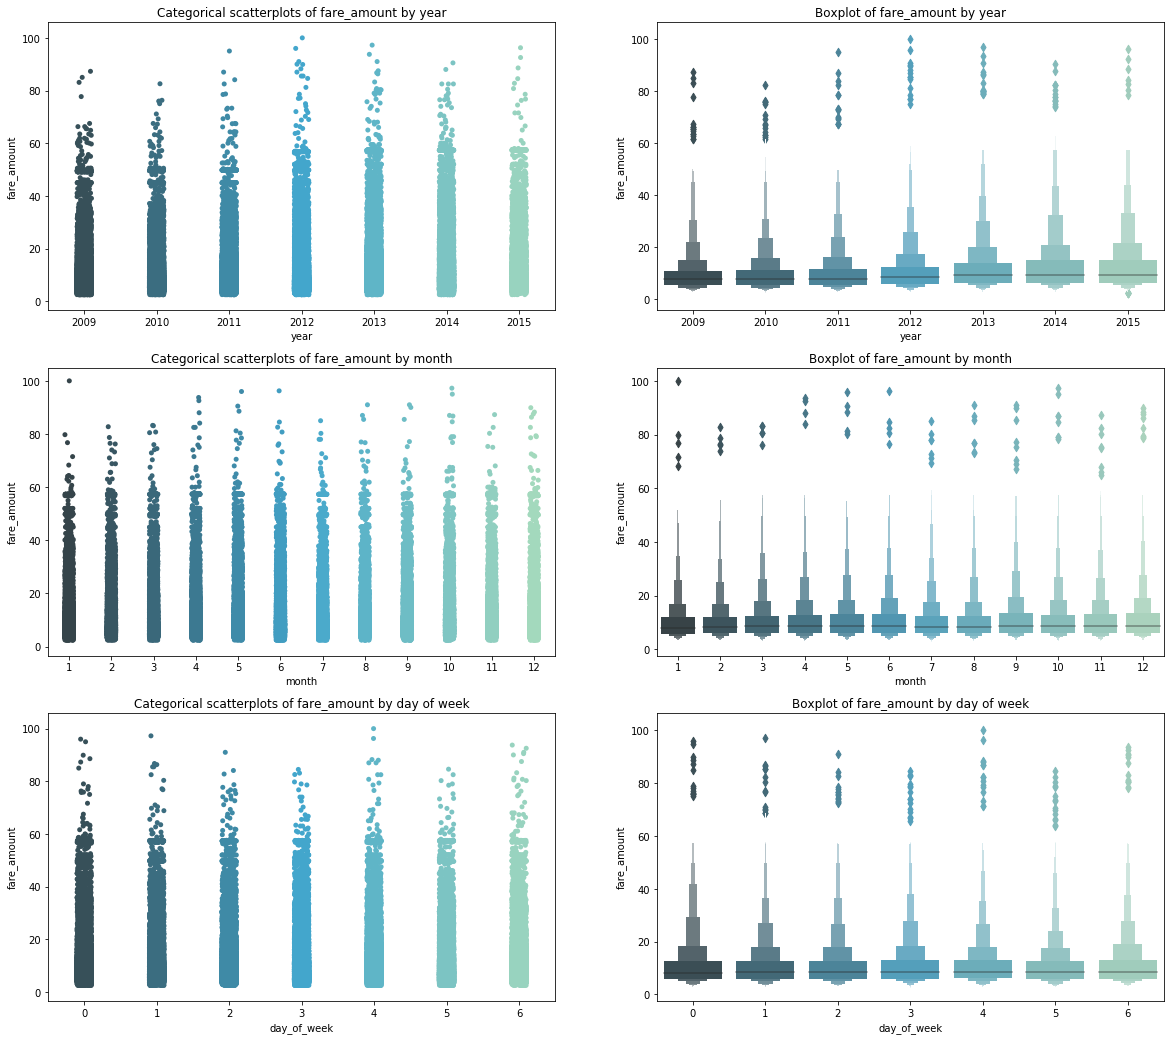

In [16]:
figure, axes = plt.subplots(3, 2, figsize = (20, 18), sharex=False, sharey=False)

plot = seaborn.catplot(x="year", y="fare_amount", data=df.sort_values("year"), ax=axes[0][0], palette="GnBu_d")
plt.close(plot.fig)
axes[0][0].set_title("Categorical scatterplots of fare_amount by year")

plot = seaborn.catplot(x="year", y="fare_amount", kind="boxen", data=df.sort_values("year"), ax=axes[0][1], palette="GnBu_d")
plt.close(plot.fig)
axes[0][1].set_title("Boxplot of fare_amount by year")

plot = seaborn.catplot(x="month", y="fare_amount", data=df.sort_values("month"), ax=axes[1][0], palette="GnBu_d")
plt.close(plot.fig)
axes[1][0].set_title("Categorical scatterplots of fare_amount by month")

plot = seaborn.catplot(x="month", y="fare_amount", kind="boxen", data=df.sort_values("month"), ax=axes[1][1], palette="GnBu_d")
plt.close(plot.fig)
axes[1][1].set_title("Boxplot of fare_amount by month")

plot = seaborn.catplot(x="day_of_week", y="fare_amount", data=df.sort_values("day_of_week"), ax=axes[2][0], palette="GnBu_d")
plt.close(plot.fig)
axes[2][0].set_title("Categorical scatterplots of fare_amount by day of week")

plot = seaborn.catplot(x="day_of_week", y="fare_amount", kind="boxen", data=df.sort_values("day_of_week"), ax=axes[2][1], palette="GnBu_d")
plt.close(plot.fig)
axes[2][1].set_title("Boxplot of fare_amount by day of week")

We can see that the first quartile, median, third quartile has increased over years. There is a tendency of rise in average taxi fare each year. Both categorical scatterplot and boxplot of taxi fare by month and day of week is almost constant.

Let's take a closer look at the average fares:

/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Average taxi fare by day_of_week')

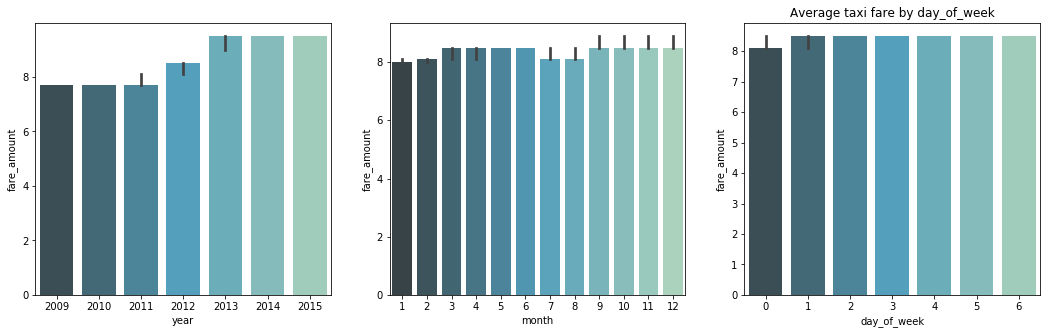

In [17]:
figure, axes = plt.subplots(1, 3, figsize = (18, 5), sharex=False, sharey=False)

seaborn.barplot(x="year", y="fare_amount", data=df.sort_values("year"), estimator=numpy.median, ax=axes[0], palette="GnBu_d")
plt.title("Average taxi fare by year")

seaborn.barplot(x="month", y="fare_amount", data=df.sort_values("month"), estimator=numpy.median, ax=axes[1], palette="GnBu_d")
plt.title("Average taxi fare by month")

seaborn.barplot(x="day_of_week", y="fare_amount", data=df.sort_values("day_of_week"), estimator=numpy.median, ax=axes[2], palette="GnBu_d")
plt.title("Average taxi fare by day_of_week")

The average taxi fair does not vary as much across months and day of weeks. January, February, June, August and Mondays has slightly lower average taxi fare.

## Task 6: Simple Linear Regression Model

In this task we will build a simple linear regression model to predict the taxi fare. Features of Euclidean distance between pickup and dropoff locations and year of travel date is taken into condsideration. About 25% of the original data is taken out as dataset to test our model with.

In [18]:
lrm = sklearn.linear_model.LinearRegression()

X = df[['eu_distance', 'year']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)

lrm.fit(X_train, y_train)
y_train_prediction = lrm.predict(X_train)
y_prediction = lrm.predict(X_test)

rmse = numpy.sqrt(sklearn.metrics.mean_squared_error(y_prediction, y_test))
rmse_1 = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train_prediction, y_train))

print("Coefficient of determination of trained dataset: %.3f" % lrm.score(X_train, y_train))
print("Coefficient of determination of test dataset: %.3f" % lrm.score(X_test, y_test))
print("RMSE: %.3f" % rmse)
print('\n')
print("Coefficients: ", numpy.frombuffer(lrm.coef_.tostring(), dtype=float))

Coefficient of determination of trained dataset: 0.764
Coefficient of determination of test dataset: 0.730
RMSE: 4.855


Coefficients:  [199.88880936   0.53230189]


/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


We can see from the coefficient that `eu_distance` is weight much more than `year`; the model heavily relies on `eu_distance`. 

The coefficient of determinations and RMSE shows how this model performs; it looks reasonable as a simple linear regression model. Next we will take this as a baseline and work on improving the model, which should have larger coefficient of determination or less RMSE. 

## Task 7: External Dataset

Below are some other dataset that I expect to help with the prediction.

1. **Dropoff datetime**

Such dataset (feature) will help identify how long a taxi ride took from pickup to dropoff. Using the time duration and distance feature we could examine the traffic condition during the ride. The traffic condition may related to year, month, day of week or hour feature, and may help predict the taxi fare more precisely.
 
2. **NYC weather data**

By intuition, people tend to use taxi (or their own cars) on rainy days and we think it will cause more traffic jams than sunny days. More traffic jams indicates passengers are stuck on the road longer, so that taxi fare goes up -- NYC weather data from 2009 to 2016 may help modeling the prediction.
 
3. **NYC traffic condition data**

Fron such dataset we could examine how traffic changes by time (year, month, date of time and hours) and find relations between taxi fare and traffic conditions by time. *Real-Time Traffic Speed Data* by NYC Open Data (https://data.cityofnewyork.us/Transportation/Real-Time-Traffic-Speed-Data/qkm5-nuaq) may be applicable to provide such feature.
 
4. **NYC street construction records**

If we could know when or where happened to have a street construction, and caused traffic to be redirected, we may consider all taxi rides passing that area during that time to take longer routes than usual. That may cause a higher taxi fare where this dataset may help predict it.
 
5. **NYC traffic accident records**

Similar to the NYC street construction records, traffic accidents may cause traffic jams and redirection as well.

## Task 8: A Better Regression Model

We will use a random forest regressor using features `eu_distance` and `year`. Configure number of estimators as 10 (default value) and maximum depth as 10.

In [19]:
rfr = sklearn.ensemble.RandomForestRegressor(max_depth=10, n_jobs=-1);

X = df[['eu_distance', 'year']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)
rfr.fit(X_train, y_train)

y_train_prediction = rfr.predict(X_train)
y_prediction = rfr.predict(X_test)

rmse = numpy.sqrt(sklearn.metrics.mean_squared_error(y_prediction, y_test))

print("Coefficient of determination of trained dataset: %.3f" % lrm.score(X_train, y_train))
print("Coefficient of determination of test dataset: %.3f" % lrm.score(X_test, y_test))
print("RMSE: %.3f" % rmse)
print('\n')
print("Coefficients: ", numpy.frombuffer(lrm.coef_.tostring(), dtype=float))

Coefficient of determination of trained dataset: 0.766
Coefficient of determination of test dataset: 0.720
RMSE: 3.793


Coefficients:  [199.88880936   0.53230189]


The random forest model uses same feature and same number of train data as the linear regression model we built in previous task.
This model has less RMSE; it performs better than the simple linear regression model. Some improvements we can make in the future is taking more features from external data source into consideration, configure the random forest regression with different estimators and depth number, or use other models.

## Task 9: Submission

This section takes the test dataset and predict the taxi fare. The prediction made by linear regression model will output as *submission_1.csv* and random forest model will output as *submission_2.csv*.

In [20]:
test_set = pandas.read_csv('test.csv')

pickup_col = test_set[['pickup_latitude', 'pickup_longitude']]
dropoff_col = test_set[['dropoff_latitude', 'dropoff_longitude']]
test_set['eu_distance'] = eu_distance(pickup_col, dropoff_col)
test_set['year'] = parse_year(test_set['pickup_datetime'])

fare_prediction_1 = lrm.predict(test_set[['eu_distance', 'year']])
fare_prediction_1 = numpy.round(fare_prediction_1, decimals=2)

fare_prediction_2 = rfr.predict(test_set[['eu_distance', 'year']])
fare_prediction_2 = numpy.round(fare_prediction_2, decimals=2)

submission_1 = pandas.DataFrame({"key": test_set['key'], "fare_amount": fare_prediction_1}, columns = ['key','fare_amount'])
submission_1.to_csv('submission_1.csv', index=False)

submission_2 = pandas.DataFrame({"key": test_set['key'], "fare_amount": fare_prediction_2}, columns = ['key','fare_amount'])
submission_2.to_csv('submission_2.csv', index=False)